  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]C:\Users\foste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:33<00:00,  9.73it/s]


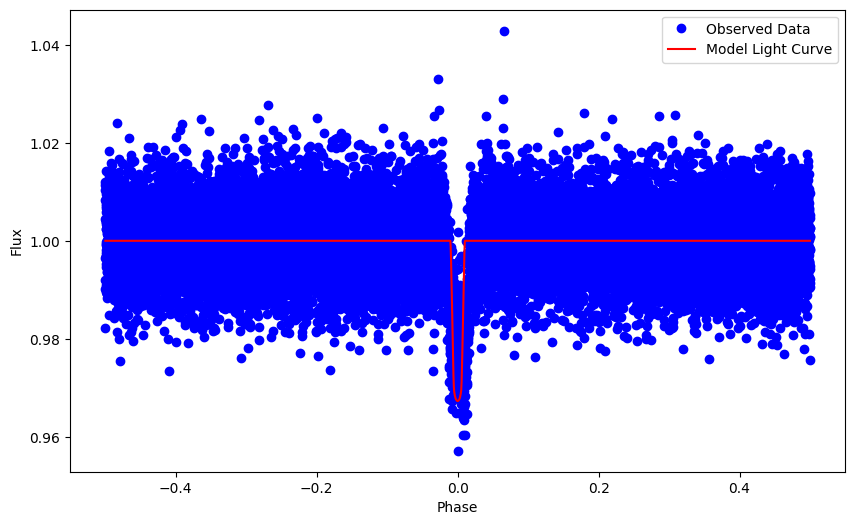

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import batman
from scipy.optimize import minimize
from scipy.signal import find_peaks
import emcee

# Load data (provide the path to your dataset)
data_planet = pd.read_csv("tess2021204101404.csv")
time_data = np.array(data_planet['time'])
flux_data = np.array(data_planet['flux'])
flux_err = np.ones_like(flux_data) * 0.001  # Assuming a constant error for simplicity

# Defines initial parameters
initial_params = batman.TransitParams()
initial_params.t0 = 2430.15                   # time of inferior conjunction; mid-transit time in days
initial_params.per = 2.770860                 # orbital period in days (estimated)
initial_params.rp = 0.1776                    # planet radius (in units of stellar radii)
initial_params.a = 15                         # semi-major axis (in units of stellar radii)
initial_params.inc = 87.47                    # orbital inclination (in degrees)
initial_params.ecc = 0                        # eccentricity
initial_params.w = 90                         # longitude of periastron (in degrees)
initial_params.limb_dark = "quadratic"        # limb darkening model
initial_params.u = [0.1, 0.3]                 # limb darkening coefficients

# Function to detect the first dip in the data
def find_first_dip(flux, prominence=0.01):
    peaks, _ = find_peaks(-flux, prominence=prominence)
    if peaks.any():
        return peaks[0]
    return None

# Define a function to generate the model light curve
def generate_model(params, time):
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

# Define a function for a preliminary fit to estimate rp
def preliminary_fit(params, time, flux):
    model_flux = generate_model(params, time)
    return np.sum((flux - model_flux) ** 2)

# Use scipy.optimize.minimize to estimate rp
def estimate_initial_rp(time, flux, initial_params):
    def objective(rp):
        params = initial_params
        params.rp = rp
        return preliminary_fit(params, time, flux)
    
    result = minimize(objective, x0=[initial_params.rp], bounds=[(0.01, 1.0)])
    return result.x[0]

# Estimate rp
initial_params.rp = estimate_initial_rp(time_data, flux_data, initial_params)

# Define a log-likelihood function for MCMC
def log_likelihood(theta, time, flux, flux_err):
    t0, rp, per, a = theta
    params = batman.TransitParams()
    params.t0 = t0
    params.rp = rp
    params.per = per
    params.a = a
    params.inc = initial_params.inc
    params.ecc = initial_params.ecc
    params.w = initial_params.w
    params.limb_dark = initial_params.limb_dark
    params.u = initial_params.u

    model = generate_model(params, time)
    sigma2 = flux_err**2

    if np.any(np.isnan(model)):
        return -np.inf

    return -0.5 * np.sum((flux - model)**2 / sigma2 + np.log(sigma2))

# Define a log-prior function for MCMC
def log_prior(theta):
    t0, rp, per, a = theta
    if (initial_params.t0 - 5 < t0 < initial_params.t0 + 5 and 
        0.1 < rp < 1.0 and 
        initial_params.per * 0.8 < per < initial_params.per * 1.2 and 
        initial_params.a * 0.1 < a < initial_params.a * 10):
        return 0.0
    return -np.inf

# Define a log-probability function for MCMC
def log_probability(theta, time, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, time, flux, flux_err)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

# Set up the MCMC sampler
nwalkers = 32
ndim = 4
initial_guess = [initial_params.t0, initial_params.rp, initial_params.per, initial_params.a]
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_data, flux_data, flux_err))

# Run MCMC
sampler.run_mcmc(pos, 5000, progress=True)

# Get the MCMC results
samples = sampler.get_chain(discard=100, thin=15, flat=True)
t0_mcmc, rp_mcmc, per_mcmc, a_mcmc = np.percentile(samples, 50, axis=0)

# Define a function to fit transit parameters and generate the model light curve
def fit_transit_parameters(time, flux, initial_params):
    # Detect the first dip
    first_dip_index = find_first_dip(flux)

    if first_dip_index is not None:
        # Use the first dip as the initial transit center time
        initial_params.t0 = time[first_dip_index]

    # Define the transit model parameters
    params = batman.TransitParams()
    params.t0 = t0_mcmc
    params.per = per_mcmc
    params.rp = rp_mcmc
    params.a = a_mcmc
    params.inc = initial_params.inc
    params.ecc = initial_params.ecc
    params.w = initial_params.w
    params.limb_dark = initial_params.limb_dark
    params.u = initial_params.u

    # Generate a finer time grid during transit for a smoother model
    time_fine = np.linspace(time[0], time[-1], len(time) * 10)
    m = batman.TransitModel(params, time_fine)

    # Initialize the BATMAN transit model with best-fit parameters
    m = batman.TransitModel(params, time)

    # Calculate the model light curve
    flux_model = m.light_curve(params)

    return flux_model, [params.t0, params.rp, params.per, params.a]

flux_model, temp_best_fit_params = fit_transit_parameters(time_data, flux_data, initial_params)

# Generate the model light curve with best-fit parameters
best_fit_params = batman.TransitParams()
best_fit_params.t0 = temp_best_fit_params[0]
best_fit_params.per = temp_best_fit_params[2]
best_fit_params.rp = temp_best_fit_params[1]
best_fit_params.a = temp_best_fit_params[3]
best_fit_params.inc = 90
best_fit_params.ecc = 0.0
best_fit_params.w = 90.0
best_fit_params.limb_dark = "nonlinear"
best_fit_params.u = [0.5, 0.1, 0.1, -0.1]

model_time = np.linspace(best_fit_params.t0 - 2.07955, best_fit_params.t0 + 2.07955, len(time_data) * 10)
model_flux = generate_model(best_fit_params, model_time)

# Phase-fold the model
model_phase = ((model_time - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Phase-fold the data
orbital_phase = ((time_data - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Phase folding the time data around the period
phase_folded_time = ((time_data - best_fit_params.t0) / best_fit_params.per) % 1
phase_folded_time[phase_folded_time > 0.5] -= 1  # Centering around 0

# Sorting the phase and corresponding flux data for plotting
sort_order = np.argsort(phase_folded_time)
sorted_phase = phase_folded_time[sort_order]
sorted_flux = flux_data[sort_order]

# Plot the observed data without connecting the blue points
plt.figure(figsize=(10, 6))
plt.plot(sorted_phase, sorted_flux, 'bo', label='Observed Data')
plt.plot(sorted_phase, flux_model[sort_order], 'r-', label='Model Light Curve')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.legend()
plt.show()
print(best_fit_params)
